In [1]:
import normflows as nf
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader
from fab import FABModel, HamiltonianMonteCarlo, Metropolis
from fab.utils.logging import ListLogger
from fab.utils.plotting import plot_history, plot_contours, plot_marginal_pair
from fab.target_distributions.gmm import GMM
from fab.utils.prioritised_replay_buffer import PrioritisedReplayBuffer
from fab import Trainer, PrioritisedBufferTrainer
from fab.utils.plotting import plot_contours, plot_marginal_pair
from experiments.make_flow import make_wrapped_normflow_realnvp
import importlib 
import models.ddpm
import models.mlp
import pdb
from tqdm import tqdm
importlib.reload(models.ddpm)
importlib.reload(models.mlp)
from models.ddpm import GaussianDiffusion, TMLP
from models.mlp import MyMLP, SpectralNormMLP

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

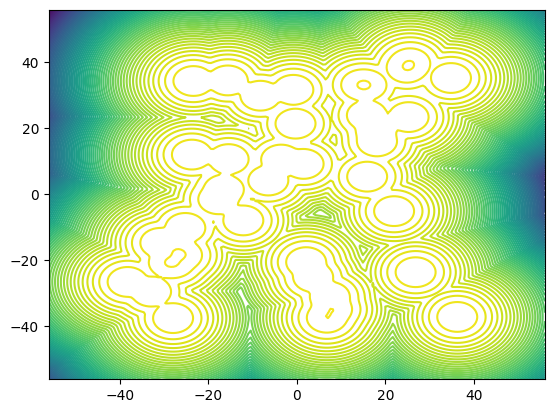

In [2]:
dim = 2
n_mixes = 40
loc_scaling = 40.0  # scale of the problem (changes how far apart the modes of each Guassian component will be)
log_var_scaling = 1.0 # variance of each Gaussian
seed = 0

torch.manual_seed(0)  # seed of 0 for GMM problem
target = GMM(dim=dim, n_mixes=n_mixes,
              loc_scaling=loc_scaling, log_var_scaling=log_var_scaling,
              use_gpu=True, true_expectation_estimation_n_samples=int(1e5))
# plot target
target.to("cpu")
fig, ax = plt.subplots()
plotting_bounds = (-loc_scaling * 1.4, loc_scaling * 1.4)
plot_contours(target.log_prob, bounds=plotting_bounds, n_contour_levels=80, ax=ax, grid_width_n_points=200)
target.to("cuda")

In [3]:
# hyper-parameters

# Flow
n_flow_layers = 15
layer_nodes_per_dim = 40
lr = 1e-4
max_gradient_norm = 100.0
batch_size = 128
n_iterations = 4000
n_eval = 10
eval_batch_size = batch_size * 10
n_plots = 10 # number of plots shows throughout tranining
use_64_bit = True
alpha = 2.0
num_samples = 10000

In [26]:
def plot_dataset(samples, gen_samples=None):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    target.to("cpu")
    plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[0], n_contour_levels=50, grid_width_n_points=200)
    
    target.to("cuda")
   
    # plot dataset samples
    plot_marginal_pair(samples, ax=axs[0], bounds=plotting_bounds)
    axs[0].set_title("Dataset samples")

    if gen_samples is not None:
        plot_contours(target.log_prob, bounds=plotting_bounds, ax=axs[1], n_contour_levels=50, grid_width_n_points=200)
        # plot generated samples
        plot_marginal_pair(gen_samples, ax=axs[1], bounds=plotting_bounds)
        axs[1].set_title("Generated samples")

    else:
        #delete subplot
        fig.delaxes(axs[1])
    plt.show()
    return [fig]


In [5]:
import pdb

def normalize(x):
    '''
        normalizes to [-1, 1]
    '''
    #pdb.set_trace()
    mins = torch.min(x, dim=0)[0]
    maxs = torch.max(x, dim=0)[0]
    ## [ 0, 1 ]
    x = (x - mins) / (maxs - mins + 1e-5)
    ## [ -1, 1 ]
    x = x * 2 - 1
    
    return x, mins, maxs

def unnormalize(x, mins, maxs):
    '''
        x : [ -1, 1 ]
    '''
    assert x.max() <= 1 and x.min() >= -1, f'x range: ({x.min():.4f}, {x.max():.4f})'
    #x = x * std + mean
    x = (x + 1) / 2
    return x * (maxs - mins) + mins

### Dataset

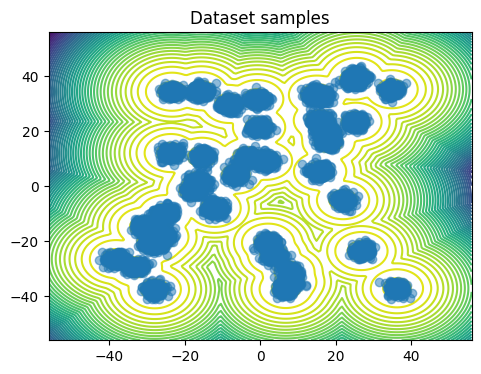

In [27]:
num_samples = 10000
dataset = target.sample(torch.tensor(num_samples).unsqueeze(0))

plot_dataset(dataset) # Visualise model during initialisation.
plt.show()

In [14]:
# normalize the dataset
dataset, global_mins, global_maxs = normalize(dataset)
train_dataset = TensorDataset(dataset)
trainloader = DataLoader(train_dataset, batch_size = 512, shuffle=True) 

### Networks

In [15]:
model = MyMLP().to(device)

reward_model = SpectralNormMLP().to(device)

diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000,          # number of steps
    auto_normalize= False      # data is already normalized, output will be in range [-1, 1]
).to(device)

opt = Adam(diffusion.parameters())

### Training Loop

In [16]:
num_train_epochs = 200

In [19]:
for epoch in tqdm(range(num_train_epochs)):
    total_loss = 0.
    for i, data in enumerate(trainloader):
        # pdb.set_trace()
        data = data[0].to(device)
        opt.zero_grad()
        loss = diffusion(data)    
        total_loss += loss.item()
        loss.backward()
        opt.step()

100%|██████████| 200/200 [00:26<00:00,  7.61it/s]


### Sampling

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

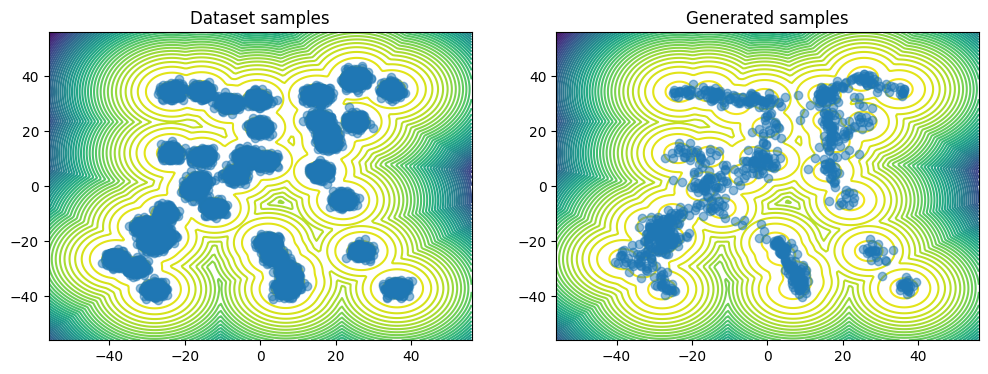

[<Figure size 1200x400 with 2 Axes>]

In [21]:
sampled_points = diffusion.sample(batch_size = 1000)
plot_dataset(unnormalize(dataset, global_mins, global_maxs), unnormalize(sampled_points, global_mins, global_maxs))

In [ ]:
outer_epochs = 10
inner_epochs = 200

# Outer Loop
for epoch in tqdm(range(outer_epochs)):
    diffusion = GaussianDiffusion(
    model,
    image_size = 2,
    timesteps = 1000,          # number of steps
    auto_normalize= False      # data is already normalized, output will be in range [-1, 1]
    ).to(device)

    opt = Adam(diffusion.parameters())

    # Reward classifier training
    